# CFRM 521 - Final Report

#### By: Wooseok (Jeff), Max, Steve, Ilse, Jasmine

----

# Introduction

# Data

In [8]:
# Load the packages (at the end we can consolidate all the packages we individually used here so that we can create a single environment.yml file for a conda environment at the end)
import pandas as pd 
import time
import numpy as np 
import os
import requests
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
import shap

# Read in the data (this section should be the same for everyone)
url = "https://api.github.com/repos/stevedemirev/CFRM521-ProjectData/contents/filtered"
response = requests.get(url)
files = response.json()

csv_files = sorted([file for file in files if file['name'].endswith('.csv')], key = lambda x: x['name'])

def get_datasets(files):
    df = pd.DataFrame()
    for file in files:
        temp = pd.read_csv(file['download_url'])
        df = pd.concat([df, temp], ignore_index = True)
    return df

full_df = get_datasets(csv_files)
full_df = full_df.sample(frac=1, random_state=42).reset_index(drop=True)
# Filter to Calls Only
full_df = full_df[full_df['type'] == "call"]

total_files = len(full_df)
train_size = int(total_files*0.7)
val_size = int(total_files*0.85)

train = full_df[:train_size]
valid = full_df[train_size:val_size]
test = full_df[val_size:]

In [9]:
display(train.head())

,contract,underlying,expiration,type,strike,style,bid,bid_size,ask,ask_size,...,theta,vega,implied_volatility,mid_price,open,high,low,close,volume_stock,adjust_close
0,V130921C00110000,V,2013-09-21,call,110.0,A,48.10,NaN,48.75,NaN,...,-1.5975,6.2814,0.2444,48.425,156.350006,158.080002,155.740005,157.990005,17884400,NaN
1,GOOG150117C00370000,GOOG,2015-01-17,call,370.0,A,415.00,NaN,419.40,NaN,...,-4.2084,43.9866,0.2792,417.200,778.400030,783.000040,773.750022,782.419993,4331200,NaN
4,BAC130322C00013500,BAC,2013-03-22,call,13.5,A,0.00,NaN,0.02,NaN,...,-0.5092,0.1719,0.3651,0.010,11.150000,11.360000,11.100000,11.300000,147145400,NaN
5,UNP130222C00115000,UNP,2013-02-22,call,115.0,A,20.30,NaN,24.10,NaN,...,-0.3341,0.0000,0.1939,22.200,137.320007,137.630005,136.119995,137.529999,4356600,NaN
8,SPG130420C00170000,SPG,2013-04-20,call,170.0,A,0.17,NaN,0.28,NaN,...,-2.7803,9.3099,0.1012,0.225,159.859990,160.599983,159.840007,160.499986,1294300,NaN


In [10]:
display(train.tail())

,contract,underlying,expiration,type,strike,style,bid,bid_size,ask,ask_size,...,theta,vega,implied_volatility,mid_price,open,high,low,close,volume_stock,adjust_close
483241,HON130921C00045000,HON,2013-09-21,call,45.0,A,24.45,NaN,27.55,NaN,...,-0.5245,1.6869,0.2736,26.000,70.809998,71.430000,70.339996,70.349998,4208900,NaN
483245,UNP130817C00160000,UNP,2013-08-17,call,160.0,A,0.26,NaN,0.40,NaN,...,-1.4590,10.4151,0.1577,0.330,132.500000,133.550003,132.110001,133.139999,3359600,NaN
483248,KO150117C00040000,KO,2015-01-17,call,40.0,A,1.49,NaN,1.60,NaN,...,-0.6720,19.6794,0.1242,1.545,37.669998,37.939999,37.009998,37.209999,19943800,NaN
483249,FCX130420C00045000,FCX,2013-04-20,call,45.0,A,0.01,NaN,0.03,NaN,...,-0.3110,0.5968,0.2275,0.020,35.840000,35.880001,35.330002,35.730000,12494200,NaN
483251,WAG130316C00046000,WAG,2013-03-16,call,46.0,A,0.00,NaN,0.05,NaN,...,-0.4653,0.1704,0.2326,0.025,41.020000,41.230000,40.670000,40.940000,6843576,NaN


In [11]:
total_size = len(train) + len(valid) + len(test)
def proportion(df):
    return round(len(df)/total_size,3)
    
print(f"Length of Training set: {len(train):,} rows, Proportion: {proportion(train)}")
print(f"Length of Validation set: {len(valid):,} rows, Proportion: {proportion(valid)}")
print(f"Length of Testing set: {len(test):,} rows, Proportion: {proportion(test)}")
print(f"Original Dataset size: {total_size:,} rows, Sum Check: {proportion(train)+proportion(valid)+proportion(test)}")

Length of Training set: 241,618 rows, Proportion: 0.7
Length of Validation set: 51,776 rows, Proportion: 0.15
Length of Testing set: 51,776 rows, Proportion: 0.15
Original Dataset size: 345,170 rows, Sum Check: 1.0


----

# Wooseok's Model

----

# Max's Model

----

# Steve's Model

## Naive Model

For my model's architecture, I decided to use 4 hidden layers with 50 neurons each with 'ReLU' activation, 'he_normal' initializer, 'Nadam' optimizer, early stopping with a patience of 10, and "MSE" as the primary loss metric, and "MAE" as the secondary loss metric. The choice to use 4 hidden layers with 50 neurons was somewhat arbitrary and not backed by any theoretical justification other than the expectation of it being able to accurately capture any non-linear relationships occuring with options pricing. The output layer would remain the default linear activation function with one neuron as we are expecting a single value, the mid price. I also chose the "ReLU" activation function for each neuron with "he_normal" initializer to better model the non-linear relationship and avoid vanishing gradients during training. Additionally, "ReLU" works well because it encourages positive only outputs, which matches with the intrinsic value of an option is defined as: $V = \text{max}(S_T - K, 0)$. The 'Nadam' optimizer was chosen here as its learning rate is adaptable, allowing it to converge faster and smoother for non-linear functions compared to other optimizers. Early stopping was added as a form of regularization to prevent unnecessary training once the model stops improving on the validation set. Given the time required to train the model, early stopping is an effective way to reduce training time while also helping to avoid overfitting. Since the objective of this project is to predict option prices, Mean Squared Error (MSE) and Mean Absolute Error (MAE) are appropriate evaluation metrics. MSE penalizes larger errors more heavily, making it useful for identifying significant prediction deviations, while MAE provides a more interpretable measure of the average prediction error.

In [12]:
def define_features(df):
    df['expiration'] = pd.to_datetime(df['expiration'])
    df['quote_date'] = pd.to_datetime(df['quote_date'])
    df['tte'] = (df['expiration'] - df['quote_date']).dt.days / 252
    X = df[['close', 'strike', 'delta', 'gamma',
            'vega', 'theta', 'implied_volatility', 'tte']]
    y = df['mid_price']
    return X, y

def get_features():
    X_feats = []
    y_feats = []
    for df in [train, valid, test]:
        df = df.copy()
        X, y = define_features(df)
        X_feats.append(X)
        y_feats.append(y)
    return X_feats, y_feats

X_feats, y_feats = get_features()
X_train, X_valid, X_test = X_feats
y_train, y_valid, y_test = y_feats

In [13]:
def scale_data(train, val, test):
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train)
    valid_scaled = scaler.transform(val)
    test_scaled = scaler.transform(test)
    return train_scaled, valid_scaled, test_scaled

def reset_session(seed=42):
    tf.keras.backend.clear_session()
    tf.random.set_seed(seed)
    np.random.seed(seed)
    
def build_model(input_shape):
    reset_session()
    model = tf.keras.Sequential([
        tf.keras.Input(shape = (input_shape,)),
        tf.keras.layers.Dense(50, activation = "relu", kernel_initializer = "he_normal"),
        tf.keras.layers.Dense(50, activation = "relu", kernel_initializer = "he_normal"),
        tf.keras.layers.Dense(50, activation = "relu", kernel_initializer = "he_normal"),
        tf.keras.layers.Dense(50, activation = "relu", kernel_initializer = "he_normal"),
        tf.keras.layers.Dense(1)
    ])
    
    model.compile(
        optimizer = "nadam",
        loss = "mse",
        metrics = ['mae']
    )
    return model

X_train_scaled, X_valid_scaled, X_test_scaled = scale_data(X_train, X_valid, X_test)

early_stop = EarlyStopping(
    monitor = "val_loss",
    patience = 10,
    mode = "min",
    restore_best_weights = True
)

In [14]:
model = build_model(X_train_scaled.shape[1])

start = time.time()
history_naive = model.fit(X_train_scaled, y_train,
             validation_data = (X_valid_scaled, y_valid),
             epochs = 50, verbose = 1, callbacks=[early_stop])
end = time.time()
naive_time = end-start

mse_val, mae_val = model.evaluate(X_valid_scaled,
                                        y_valid, verbose = 0)
test_loss, test_mae = model.evaluate(X_test_scaled,
                                        y_test, verbose = 0)

print("\nNaive Model:")
print(f"Validation MSE: {mse_val}")
print(f"Validation MAE: {mae_val}")

print(f"\nTest MSE: {test_loss}")
print(f"Test MAE: {test_mae}")

Epoch 1/50


2025-06-05 11:38:23.342399: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


7551/7551 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 259.0185 - mae: 4.0349 - val_loss: 2.4919 - val_mae: 0.8544
Epoch 2/50
7551/7551 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 2.3944 - mae: 0.7585 - val_loss: 2.5975 - val_mae: 0.8770
Epoch 3/50
7551/7551 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 1.8460 - mae: 0.6195 - val_loss: 2.5935 - val_mae: 0.8573
Epoch 4/50
7551/7551 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 1.5776 - mae: 0.5433 - val_loss: 2.0460 - val_mae: 0.7853
Epoch 5/50
7551/7551 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 1.4283 - mae: 0.4995 - val_loss: 1.6346 - val_mae: 0.6770
Epoch 6/50
7551/7551 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 1.2917 - mae: 0.4575 - val_loss: 1.4234 - val_mae: 0.6015
Epoch 7/50
7551/7551 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 1.2365 - mae: 0.4374 - val_loss: 1.4606 - val_mae: 0.6120
Epoch 8/50
7551/7551 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 1.1972 - mae: 0.4203 - val_loss: 1.5871 - val_mae: 0.6351
Epoch 9/50
7551/7551 ━━━━━━━━━━━━━━━━━━━━

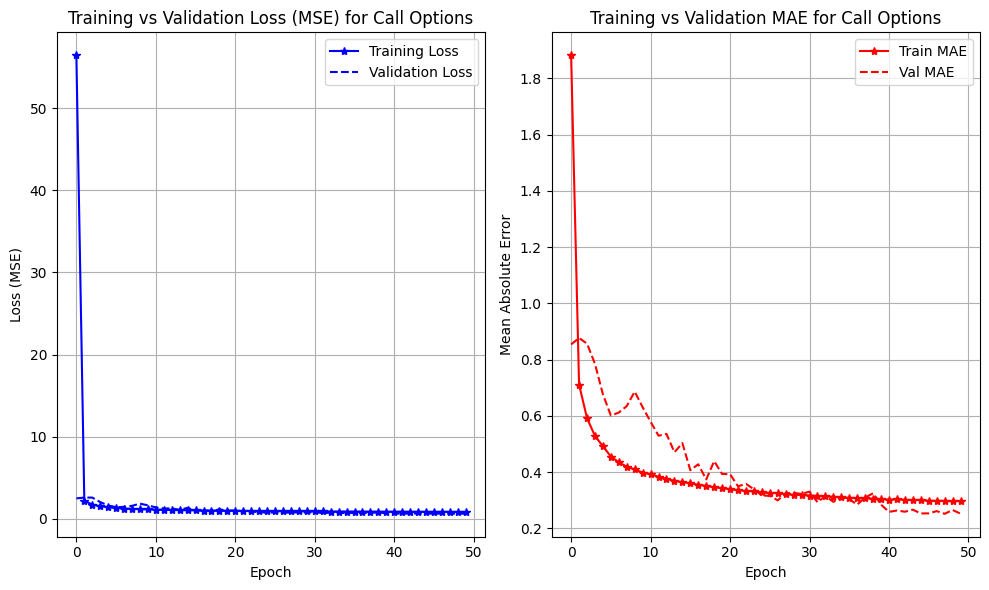

In [15]:
def plot_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 6))

    ax1.plot(history.epoch, history.history["loss"], '*-', label="Training Loss", color='b')
    ax1.plot(history.epoch, history.history["val_loss"], '--', label="Validation Loss", color='b')
    ax1.set_title("Training vs Validation Loss (MSE) for Call Options")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss (MSE)")
    ax1.grid(True)
    ax1.legend()
    
    ax2.plot(history.epoch, history.history["mae"], '*-', label="Train MAE", color='r')
    ax2.plot(history.epoch, history.history["val_mae"], '--', label="Val MAE", color='r')
    ax2.set_title("Training vs Validation MAE for Call Options")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Mean Absolute Error")
    ax2.grid(True)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

plot_learning_curves(history_naive)

As we can see from the learning curves above, the training loss and the validation loss converge closely, suggesting that the model is learning effectively without overfitting. We can also confirm this by looking at the training and validation MAE which also converges.

1618/1618 ━━━━━━━━━━━━━━━━━━━━ 1s 668us/step


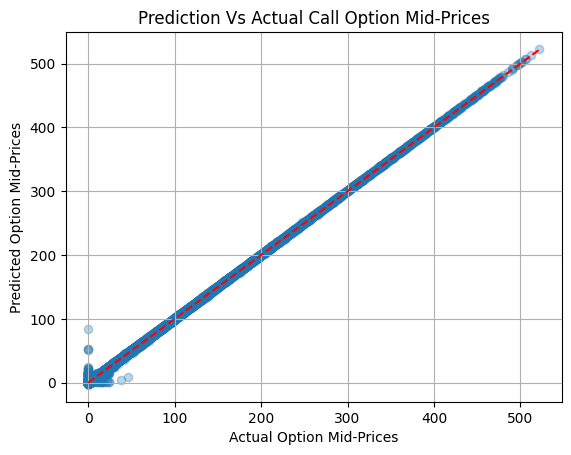

In [16]:
def get_prediction_plot(model, X_test_s, y_test):
    y_pred = model.predict(X_test_s)
    
    plt.scatter(y_test, y_pred, marker = 'o', alpha = 0.3)
    plt.plot([y_test.min(), y_test.max()], 
             [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual Option Mid-Prices")
    plt.ylabel("Predicted Option Mid-Prices")
    plt.title(f"Prediction Vs Actual Call Option Mid-Prices")
    plt.grid(True)
    plt.show()

get_prediction_plot(model, X_test_scaled, 
                    y_test)

This plot allows us to visualize how well the model predicted the mid-price of the option, with a perfectly diagonal line indicating all the predictions were completely accurate. The model does seem to follow this diagonal line but there is a noticeable deviation around 0 where predictions seem to be less accurate.

ExactExplainer explainer: 51777it [32:36, 26.41it/s]                           
/tmp/ipykernel_61240/3586862037.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_valid_scaled, feature_names = ['close', 'strike', 'delta', 'gamma',


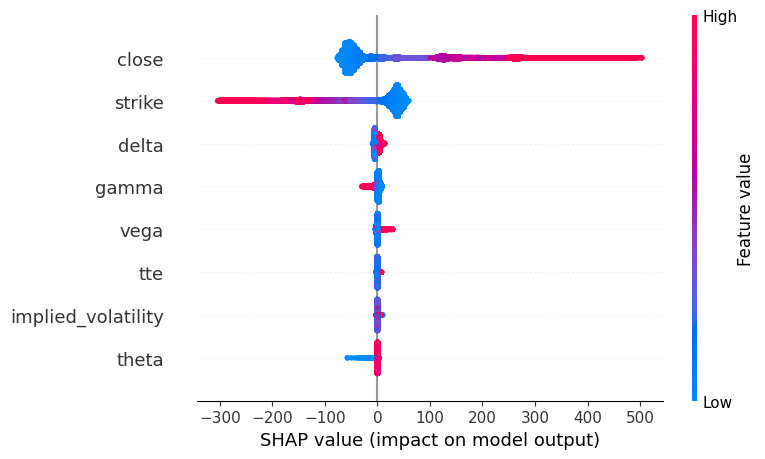

In [17]:
def plot_shap(model):
    explainer = shap.Explainer(model, X_train_scaled)
    shap_values = explainer(X_valid_scaled)
    shap.summary_plot(shap_values, X_valid_scaled, feature_names = ['close', 'strike', 'delta', 'gamma',
            'vega', 'theta', 'implied_volatility', 'tte'])

plot_shap(model)

The SHAP plot above showcases the order of importance for each feature we included, as we can see the top feature was `close` which meant it had the highest impact on model predictions, followed by the strike price of the call option, the delta, the gamma, the vega, time to expiry, implied volatility, and then theta. Intuitively this makes sense since the value of a call option is defined as $V = \text{max}(S_T - K, 0)$ where $S_T$ is the current underlying price (`close`) and $K$ is the strike price (`strike`). These two inputs directly determine the intrinsic value of the option which is why their values dominantly impact our model.

## Hyperparameter search

To optimize the Neural Network model, we want to identify the best hyperparameter configuration which predicts the option's `mid_price` closest, to do this I will implement a randomized search. 

A few of the hyperparameters to optimize are: 
* Number of Hidden Layers
* Number of Neurons per layer
* Neuron activation function
* Neuron l2 regularization
* Learning rate
* Optimizer

To find the best configuration, we will select the number of hidden layers between 1 and 5, as adding more may be redundant. For the number of neurons, we will select a value between 10 and 100 neurons. Since deep neural networks often perform better with 'swish' activation rather than with 'ReLU', we will select the activation function between those two at random to assess which performs better. Our l2 regularizer and learning rate will both be chosen from a range between 1e-6 and 1e-2 to allow a broader range of values in which to assess performance on. Lastly, the optimizer will be selected at random as either the 'Adam' optimizer or the adam optimizer with nesterov momentum ('Nadam') to assess which fits the model better. Once again we will include early stopping to avoid unneccessary training, but this time with a patience of 5, as we will only be training on 20 epochs instead of 50 due to time constraints. This randomized search will run for 30 iterations in order to assess the optimal parameters, which we will then compare the best model here against the naive model on their test set performance.

In [18]:
def reset_session(seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    tf.keras.backend.clear_session()

def build_model(hp):
    reset_session()

    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape = (X_train.shape[1],)))

    n_hidden = hp.Int("n_hidden", 1, 5)
    for i in range(n_hidden):
        model.add(tf.keras.layers.Dense(
            hp.Int(f"n_neurons_{i+1}", 10, 100),
            activation = hp.Choice("activation", ["relu", 'swish']),
            kernel_regularizer = tf.keras.regularizers.l2(
            hp.Float("l2", 1e-6, 1e-2, sampling="log")
            ),
            kernel_initializer = "he_normal"
        ))
        
    model.add(tf.keras.layers.Dense(1))
    
    learning_rate = hp.Float("learning_rate", 1e-6, 1e-2, sampling = "log")
    optimizer_name = hp.Choice("optimizer", ["Adam", "Nadam"])
    
    if optimizer_name == "Adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)
  
    model.compile(loss="mse", metrics = ['mae'], optimizer=optimizer)
    return model

early_stop = EarlyStopping(
    monitor = "val_loss",
    patience = 5,
    mode = "min",
    restore_best_weights = True
)

In [19]:
random_search_tuner = kt.RandomSearch(
    build_model, 
    objective = "val_loss", 
    seed = 42, 
    max_trials = 30, 
    overwrite = True
)

random_search_tuner.search(X_train_scaled, y_train, epochs = 20, 
                    validation_data = (X_valid_scaled, y_valid), verbose = 1,
                          callbacks=[early_stop])

Trial 30 Complete [00h 05m 11s]
val_loss: 13.772773742675781

Best val_loss So Far: 0.7053834795951843
Total elapsed time: 02h 06m 27s


In [20]:
best_hyperparams = random_search_tuner.get_best_hyperparameters(num_trials = 1)[0]
best_hyperparams.values

{'n_hidden': 2,
 'n_neurons_1': 72,
 'activation': 'relu',
 'l2': 2.4393425805289897e-05,
 'learning_rate': 0.0004931548860319096,
 'optimizer': 'Nadam',
 'n_neurons_2': 82,
 'n_neurons_3': 20,
 'n_neurons_4': 88,
 'n_neurons_5': 72}

In [21]:
best_model = build_model(best_hyperparams)

start = time.time()
history_best = best_model.fit(X_train_scaled, y_train,
             validation_data = (X_valid_scaled, y_valid),
             epochs = 50, verbose = 1, callbacks=[early_stop])
end = time.time()
tuned_model_time = end - start

test_loss_best, test_mae_best = best_model.evaluate(X_test_scaled, y_test)
print("\nTest MSE:", test_loss_best)
print("Test MAE:", test_mae_best)

Epoch 1/50
7551/7551 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 720.9119 - mae: 8.9819 - val_loss: 7.8404 - val_mae: 1.4825
Epoch 2/50
7551/7551 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 6.7356 - mae: 1.2794 - val_loss: 2.4278 - val_mae: 0.7891
Epoch 3/50
7551/7551 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 2.6895 - mae: 0.7661 - val_loss: 1.5123 - val_mae: 0.5913
Epoch 4/50
7551/7551 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 1.8368 - mae: 0.6124 - val_loss: 1.2731 - val_mae: 0.5310
Epoch 5/50
7551/7551 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 1.5562 - mae: 0.5390 - val_loss: 1.0740 - val_mae: 0.4588
Epoch 6/50
7551/7551 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 1.4356 - mae: 0.4922 - val_loss: 1.0008 - val_mae: 0.4301
Epoch 7/50
7551/7551 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 1.3245 - mae: 0.4654 - val_loss: 0.9736 - val_mae: 0.4185
Epoch 8/50
7551/7551 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 1.2819 - mae: 0.4447 - val_loss: 0.9348 - val_mae: 0.4017
Epoch 9/50
7551/7551 ━━━━━━━━━

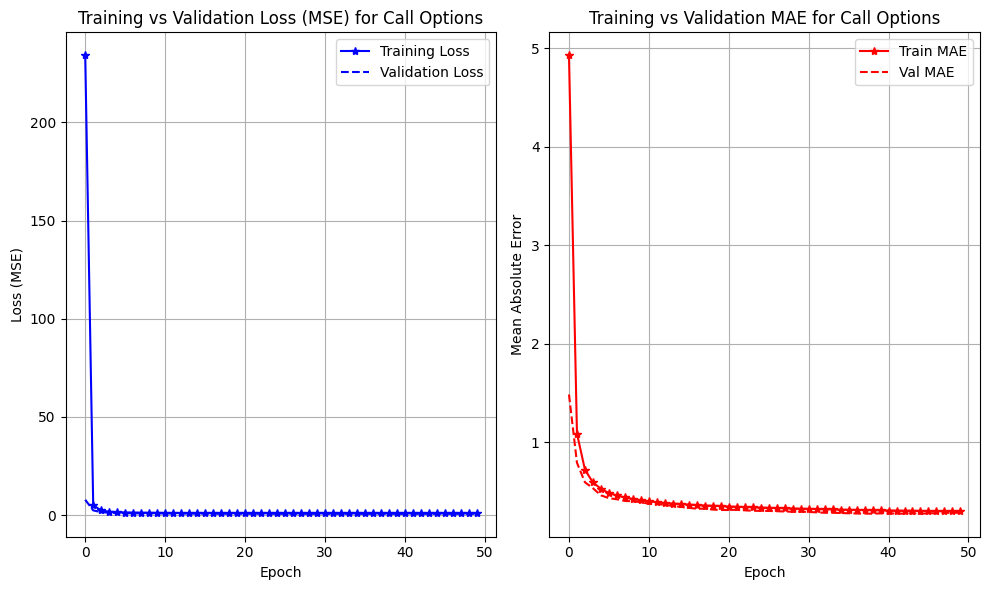

In [22]:
plot_learning_curves(history_best)

1618/1618 ━━━━━━━━━━━━━━━━━━━━ 1s 692us/step


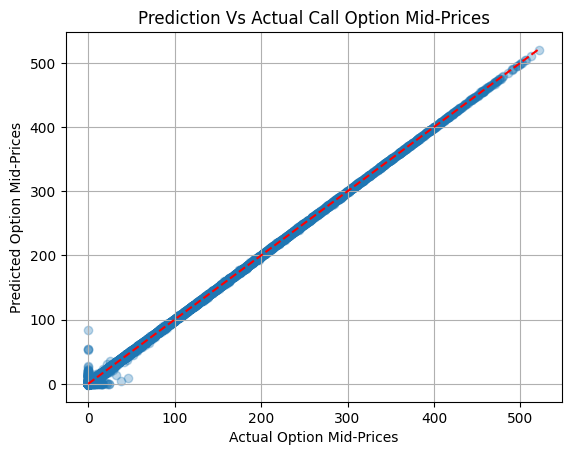

In [23]:
get_prediction_plot(best_model, X_test_scaled, 
                    y_test)

ExactExplainer explainer: 51777it [24:10, 35.45it/s]                           
/tmp/ipykernel_61240/3586862037.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_valid_scaled, feature_names = ['close', 'strike', 'delta', 'gamma',


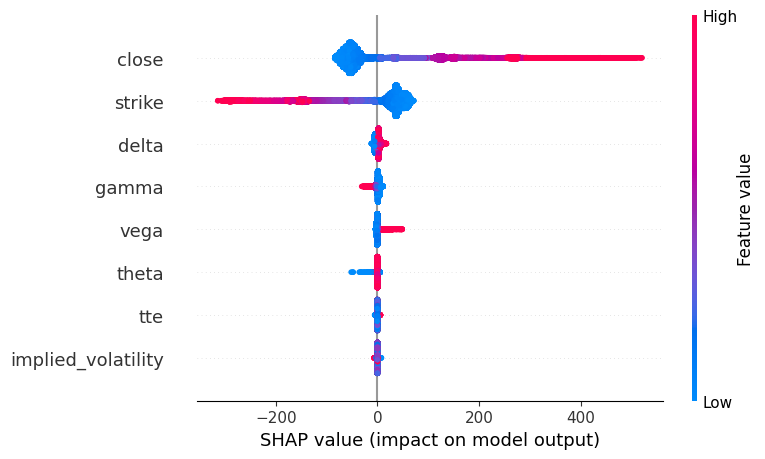

In [24]:
plot_shap(best_model)

In [25]:
results_df = pd.DataFrame([
    {
        'Model': 'Naive',
        'Layers': 4,
        'Activation': "ReLU",
        'Optimizer': "Nadam",
        'Epochs': 50,
        'Test MAE': round(test_mae, 4),
        'Test MSE': round(test_loss, 4),
        'Train Time (s)': round(naive_time, 2)
    },
    {
        'Model': 'Tuned',
        'Layers': int(best_hyperparams['n_hidden']),
        'Activation': str(best_hyperparams['activation']),
        'Optimizer': str(best_hyperparams['optimizer']),
        'Epochs': max(history_best.epoch)+1,
        'Test MAE': round(test_mae_best, 4),
        'Test MSE': round(test_loss_best, 4),
        'Train Time (s)': round(tuned_model_time, 2)
    }
])

display(results_df)

,Model,Layers,Activation,Optimizer,Epochs,Test MAE,Test MSE,Train Time (s)
0,Naive,4,ReLU,Nadam,50,0.2547,0.8000,653.12
1,Tuned,2,relu,Nadam,50,0.2779,0.9127,627.94


As we can see from the plots above, the hyperparameter tuned model also doesn't seem to be overfitting as the training loss metrics converge nicely with the validation losses. The predictions seem to be slightly worse compared to the naive model as we encounter more incorrectly estimated values around 0, this can be reinforced from the test MSE and test MAE which were higher compared to the naive model. 

Regardless, the hyperparameter tuned model seemed to use the same activation function and optimizer as our naive model did, possibly indicating these were better parameters than "swish" activation and "adam" optimizer we were evaluating against. The number of hidden layers in the tuned model was also less than the naive model, which allowed for a slightly faster training speed at the cost of slightly worse predictions. 

In summary, the hyperparameter optimization did not yield a significant improvement over our initial model architecture. This suggests that the naive model was already well-suited for the task. For future work, we could build upon the naive model by performing another randomized search, but this time focusing only on optimizing the l2 regularization and the learning rate parameters which could further improve the model's performance.

----

# Ilse's Model

----

# Jasmine's Model

----

# Conclusions